In [81]:
# Importação das bibliotecas necessárias

import boto3
from botocore import UNSIGNED
from botocore.client import Config
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

In [3]:
s3 = boto3.resource("s3", config=Config(signature_version=UNSIGNED))

In [4]:
s3_bucket = s3.Bucket('nyc-tlc')

In [5]:
# Ficheiros presentes no dataset

for my_bucket_object in s3_bucket.objects.all():
    if (my_bucket_object.size/1024/1024/1024) > 1.7:
     print(my_bucket_object.key, my_bucket_object.size/1024/1024/1024)

trip data/yellow_tripdata_2009-01.csv 2.3637942634522915
trip data/yellow_tripdata_2009-02.csv 2.249560944736004
trip data/yellow_tripdata_2009-03.csv 2.4210419980809093
trip data/yellow_tripdata_2009-04.csv 2.406269527040422
trip data/yellow_tripdata_2009-05.csv 2.491463811136782
trip data/yellow_tripdata_2009-06.csv 2.394559129141271
trip data/yellow_tripdata_2009-07.csv 2.3006204795092344
trip data/yellow_tripdata_2009-08.csv 2.310441732406616
trip data/yellow_tripdata_2009-09.csv 2.360710578970611
trip data/yellow_tripdata_2009-10.csv 2.637480964884162
trip data/yellow_tripdata_2009-11.csv 2.444788286462426
trip data/yellow_tripdata_2009-12.csv 2.497821459546685
trip data/yellow_tripdata_2010-01.csv 2.540702736005187
trip data/yellow_tripdata_2010-02.csv 1.9072604440152645
trip data/yellow_tripdata_2010-03.csv 2.2041680850088596
trip data/yellow_tripdata_2010-04.csv 2.5867342930287123
trip data/yellow_tripdata_2010-05.csv 2.644806300289929
trip data/yellow_tripdata_2010-06.csv 2.53

In [20]:
# Transferência dos dados relativos ao mês de julho de 2014

s3_bucket.download_file('trip data/yellow_tripdata_2014-07.csv', 'Dataset Taxis and Limosines/julho_2014.csv')

In [21]:
# Transferência dos dados relativos ao mês de agosto de 2014

s3_bucket.download_file('trip data/yellow_tripdata_2014-08.csv', 'Dataset Taxis and Limosines/agosto_2014.csv')

In [6]:
# Algumas importações relativos ao Spark que iremos usar daqui em diante

import sys

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import Imputer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

In [7]:
# Criação de uma sessão spark

spark = SparkSession\
    .builder\
    .appName("AirBnB")\
    .config("spark.sql.shuffle.partitions",6)\
    .getOrCreate()

In [8]:
# Ver o caminho para a pasta contendo o dataset

! pwd

/home/big/praticas/Trabalho_Grupo


In [9]:
# Ler o dataset

taxis_and_limosines = spark.read.csv('/home/big/praticas/Trabalho_Grupo/Dataset Taxis and Limosines', header="true", inferSchema="true", sep=',')

In [10]:
# Informações sobre os dados - 5 primeiras linhas, o esquema e o número total de registos

taxis_and_limosines.show(5, vertical = True)
taxis_and_limosines.printSchema()
taxis_and_limosines.count()

-RECORD 0----------------------------------
 vendor_id           | CMT                 
  pickup_datetime    | 2014-07-10 10:07:55 
  dropoff_datetime   | 2014-07-10 10:16:19 
  passenger_count    | 1                   
  trip_distance      | 1.2                 
  pickup_longitude   | -73.981241          
  pickup_latitude    | 40.781829           
  rate_code          | 1                   
  store_and_fwd_flag | N                   
  dropoff_longitude  | -73.974051          
  dropoff_latitude   | 40.78732            
  payment_type       | CSH                 
  fare_amount        | 7.5                 
  surcharge          | 0.0                 
  mta_tax            | 0.5                 
  tip_amount         | 0.0                 
  tolls_amount       | 0.0                 
  total_amount       | 8.0                 
-RECORD 1----------------------------------
 vendor_id           | CMT                 
  pickup_datetime    | 2014-07-10 09:06:52 
  dropoff_datetime   | 2014-07-1

25795242

In [ ]:
# Significado das colunas:

# vendor_id - Um código em string indicando o provedor associado ao registo de viagem
# pickup_datetime - Data do início da viagem
# dropoff_datetime - Data do fim da viagem
# passenger_count - Número de passageiros da viagem
# trip_distance - Distância da viagem
# pickup_longitude - Longitude do sítio de início da viagem
# pickup_latitude - Latitude do sítio de início da viagem
# rate_code - Tarifa da rota
# store_and_fwd_flag - Se o registo da viagem foi guardado na memória do veículo antes de ter sido enviado para o provedor
# dropoff_longitude - Longitude do fim da viagem
# dropoff_latitude - Latitude do fim da viagem
# payment_type - Tipo de pagamento 
# fare_amount - Valor das tarifas da viagem
# surcharge - Valor das sobretaxas da viagem
# mta_tax - Imposto cobrado a serviços prestados da área dos transportes
# tip_amount - Valor da gorjeta
# tolls_amount - Valor das portagens da viagem
# total_amount - Total pago pela viagem

In [11]:
# Vamos ver se existem NULLS

[taxis_and_limosines.count(), taxis_and_limosines.dropna().count()]

# Quase metade das linhas do dataset inteiro têm pelo menos um registo NULL

[25795242, 12484250]

In [12]:
# Definição de uma subamostra por questões de produtividade para tarefas intesivas e frequentes

# Escolheu-se uma subamostra que seja corresponda a 10% dos dados referentes ao mês de agosto

# Ler o ficheiro apenas referente ao mês de agosto

taxis_and_limosines_agosto =  spark.read.csv('/home/big/praticas/Trabalho_Grupo/Dataset Taxis and Limosines/agosto_2014.csv', header="true", inferSchema="true", sep=',')

# Número de linhas deste ficheiro

taxis_and_limosines_agosto.count()

# Subamostra

taxis_and_limosines_subamostra = taxis_and_limosines_agosto.sample(False, fraction = 0.10)

taxis_and_limosines_subamostra.count()

1269809

In [13]:
# Adição da variável Trip Duration à subamostra para efeitos de implementação do algoritmo

taxis_and_limosines_subamostra = taxis_and_limosines_subamostra.withColumn(' pickup_datetime', to_timestamp(" pickup_datetime","yyyy-MM-dd HH:mm:ss"))
taxis_and_limosines_subamostra = taxis_and_limosines_subamostra.withColumn(' dropoff_datetime',to_timestamp(" dropoff_datetime","yyyy-MM-dd HH:mm:ss"))
taxis_and_limosines_subamostra = taxis_and_limosines_subamostra.withColumn(' trip_duration',col(" dropoff_datetime").cast("long") - col(' pickup_datetime').cast("long"))

In [14]:
# Valores na coluna rate_count

taxis_and_limosines_subamostra.select(taxis_and_limosines.columns[7]).distinct().show()

+----------+
| rate_code|
+----------+
|         2|
|         5|
|         4|
|         1|
|         6|
|         3|
|         0|
+----------+



In [15]:
# Existem valores inválidos no dataset para esta coluna (rate_code), vamos eliminá-los caso apareçam na nossa subamostra

taxis_and_limosines_subamostra = taxis_and_limosines_subamostra[taxis_and_limosines_subamostra[' rate_code'] < 7]

In [16]:
# Diferentes tipos de pagamento utilizados

taxis_and_limosines_subamostra.select(taxis_and_limosines.columns[11]).distinct().show()

+-------------+
| payment_type|
+-------------+
|          DIS|
|          UNK|
|          CRD|
|          CSH|
|          NOC|
+-------------+



In [17]:
# Informação relevante sobre a coluna_passenger

taxis_and_limosines_subamostra.select(taxis_and_limosines.columns[3]).distinct().sort(taxis_and_limosines.columns[3]).show()

+----------------+
| passenger_count|
+----------------+
|               0|
|               1|
|               2|
|               3|
|               4|
|               5|
|               6|
|               9|
+----------------+



In [18]:
# Informação relevante sobre a coluna store_and_fwd_flag

taxis_and_limosines_subamostra.groupBy(taxis_and_limosines.columns[8]).count().show(vertical=True)

-RECORD 0---------------------
  store_and_fwd_flag | null   
 count               | 658563 
-RECORD 1---------------------
  store_and_fwd_flag | N      
 count               | 598608 
-RECORD 2---------------------
  store_and_fwd_flag | Y      
 count               | 12638  



In [99]:
# Medidas descritivas para cada coluna

for cl in taxis_and_limosines_subamostra.columns:
    taxis_and_limosines_subamostra.describe(cl).show()

+-------+---------+
|summary|vendor_id|
+-------+---------+
|  count|  1261301|
|   mean|     null|
| stddev|     null|
|    min|      CMT|
|    max|      VTS|
+-------+---------+

+-------+
|summary|
+-------+
|  count|
|   mean|
| stddev|
|    min|
|    max|
+-------+

+-------+
|summary|
+-------+
|  count|
|   mean|
| stddev|
|    min|
|    max|
+-------+



+-------+------------------+
|summary|   passenger_count|
+-------+------------------+
|  count|           1261301|
|   mean| 1.711297303339964|
| stddev|1.3604214277423146|
|    min|                 0|
|    max|                 9|
+-------+------------------+



+-------+------------------+
|summary|     trip_distance|
+-------+------------------+
|  count|           1261301|
|   mean|3.0836510555371097|
| stddev|3.6084849929493803|
|    min|              0.01|
|    max|              90.4|
+-------+------------------+



+-------+------------------+
|summary|  pickup_longitude|
+-------+------------------+
|  count|           1261301|
|   mean|-72.09008828872435|
| stddev|11.659093032698085|
|    min|        -93.708367|
|    max|        154.100756|
+-------+------------------+



+-------+-----------------+
|summary|  pickup_latitude|
+-------+-----------------+
|  count|          1261301|
|   mean|39.71111436572311|
| stddev|6.421036716136723|
|    min|       -23.421967|
|    max|        58.512415|
+-------+-----------------+



+-------+-------------------+
|summary|          rate_code|
+-------+-------------------+
|  count|            1261301|
|   mean| 1.0310639569777555|
| stddev|0.23183876636677006|
|    min|                  0|
|    max|                  6|
+-------+-------------------+



+-------+-------------------+
|summary| store_and_fwd_flag|
+-------+-------------------+
|  count|             606282|
|   mean|               null|
| stddev|               null|
|    min|                  N|
|    max|                  Y|
+-------+-------------------+



+-------+------------------+
|summary| dropoff_longitude|
+-------+------------------+
|  count|           1261301|
|   mean|-72.23015520502157|
| stddev|11.225723014664586|
|    min|       -162.399191|
|    max|        154.100756|
+-------+------------------+



+-------+-----------------+
|summary| dropoff_latitude|
+-------+-----------------+
|  count|          1261301|
|   mean| 39.7892724942564|
| stddev|6.183348052445368|
|    min|       -23.421967|
|    max|        62.208182|
+-------+-----------------+



+-------+-------------+
|summary| payment_type|
+-------+-------------+
|  count|      1261301|
|   mean|         null|
| stddev|         null|
|    min|          CRD|
|    max|          UNK|
+-------+-------------+



+-------+------------------+
|summary|       fare_amount|
+-------+------------------+
|  count|           1261301|
|   mean|12.782188636970872|
| stddev|10.423297465614677|
|    min|               2.5|
|    max|             500.0|
+-------+------------------+



+-------+-------------------+
|summary|          surcharge|
+-------+-------------------+
|  count|            1261301|
|   mean| 0.3242264059094538|
| stddev|0.35967529347790894|
|    min|                0.0|
|    max|               10.0|
+-------+-------------------+



+-------+--------------------+
|summary|             mta_tax|
+-------+--------------------+
|  count|             1261301|
|   mean| 0.49856497378500453|
| stddev|0.026747978886174792|
|    min|                 0.0|
|    max|                 0.5|
+-------+--------------------+



+-------+------------------+
|summary|        tip_amount|
+-------+------------------+
|  count|           1261301|
|   mean|1.4685871096590095|
| stddev|  2.26174124444934|
|    min|               0.0|
|    max|             150.0|
+-------+------------------+



+-------+------------------+
|summary|      tolls_amount|
+-------+------------------+
|  count|           1261301|
|   mean|0.2904895025057675|
| stddev|1.3028893939678319|
|    min|               0.0|
|    max|              20.0|
+-------+------------------+



+-------+------------------+
|summary|      total_amount|
+-------+------------------+
|  count|           1261301|
|   mean| 15.36417558536777|
| stddev|12.579660573350289|
|    min|               2.5|
|    max|             500.0|
+-------+------------------+



+-------+-----------------+
|summary|    trip_duration|
+-------+-----------------+
|  count|          1261301|
|   mean|793.6758307493611|
| stddev|601.0239219700204|
|    min|                1|
|    max|            33022|
+-------+-----------------+



In [98]:
# Eliminação dos valores incorretos da variável trip_duration e trip_distance

taxis_and_limosines_subamostra = taxis_and_limosines_subamostra[taxis_and_limosines_subamostra[' trip_duration'] <= 36000]
taxis_and_limosines_subamostra = taxis_and_limosines_subamostra[taxis_and_limosines_subamostra[' trip_duration'] > 0]
taxis_and_limosines_subamostra = taxis_and_limosines_subamostra[taxis_and_limosines_subamostra[' trip_distance'] > 0]

In [22]:
# Informação relevante sobre a coluna payment_type

payment_method = taxis_and_limosines_subamostra.select(' passenger_count',' trip_distance',' fare_amount',' surcharge',
                                                       ' mta_tax',' tip_amount',' tolls_amount', 
                                                       ' total_amount',' payment_type').groupBy(taxis_and_limosines.columns[11]).sum()

payment_method.show(vertical=True)

payment_method_pandas = payment_method.toPandas()

payment_method_final = payment_method_pandas.transpose()

print(payment_method_final)

-RECORD 0-------------------------------------
  payment_type         | DIS                  
 sum( passenger_count) | 1400                 
 sum( trip_distance)   | 3720.1               
 sum( fare_amount)     | 15735.27             
 sum( surcharge)       | 362.5                
 sum( mta_tax)         | 534.5                
 sum( tip_amount)      | 2.1                  
 sum( tolls_amount)    | 458.4299999999999    
 sum( total_amount)    | 17092.799999999996   
-RECORD 1-------------------------------------
  payment_type         | UNK                  
 sum( passenger_count) | 12039                
 sum( trip_distance)   | 16414.719999999998   
 sum( fare_amount)     | 69081.0              
 sum( surcharge)       | 1846.0               
 sum( mta_tax)         | 2862.0               
 sum( tip_amount)      | 12452.199999999999   
 sum( tolls_amount)    | 1166.1100000000001   
 sum( total_amount)    | 87407.30999999995    
-RECORD 2-------------------------------------
  payment_typ

                              0         1            2           3         4
 payment_type               DIS       UNK          CRD         CSH       NOC
sum( passenger_count)      1400     12039      1201148      944917      4468
sum( trip_distance)      3720.1  16414.72   2337410.19  1521976.05    9891.1
sum( fare_amount)      15735.27   69081.0   9602244.59  6470047.27   45545.0
sum( surcharge)           362.5    1846.0    237073.33   169428.26    1258.0
sum( mta_tax)             534.5    2862.0     356531.0    268996.0    1731.0
sum( tip_amount)            2.1   12452.2   1849177.65      118.05     16.58
sum( tolls_amount)       458.43   1166.11    244357.64   121351.95    963.47
sum( total_amount)      17092.8  87407.31  12289384.21  7030091.57  49514.05


In [23]:
valores_medios = []

for i in range(0, payment_method_final.shape[1]):
    valores_medios.append(payment_method_final[i][8] / payment_method_final[i][1])
    print(payment_method_final[i][0], payment_method_final[i][8] / payment_method_final[i][1])

DIS 12.209142857142854
UNK 7.260346374283575
CRD 10.231365502002985
CSH 7.439903790491653
NOC 11.08192703670546


In [24]:
nomes_pagamento = ['DIS', 'UNK', 'CRD', 'CSH', 'NOC']

data = {'Método de pagamento': nomes_pagamento, 'Total médio pago por passageiro': valores_medios}
df_valores_medios = pd.DataFrame(data)

df_valores_medios

,Método de pagamento,Total médio pago por passageiro
0,DIS,12.209143
1,UNK,7.260346
2,CRD,10.231366
3,CSH,7.439904
4,NOC,11.081927


<AxesSubplot:xlabel='Método de pagamento', ylabel='Total médio pago por passageiro'>

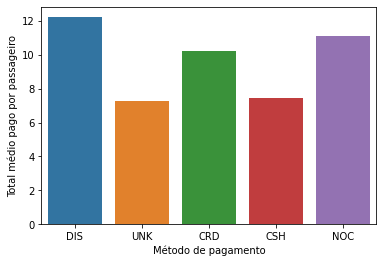

In [25]:
# Histograma do total médio por passageiro por método de pagamento

sns.barplot(data = df_valores_medios, x = df_valores_medios['Método de pagamento'], y = df_valores_medios['Total médio pago por passageiro'])

In [26]:
# Informação relevante sobre a coluna código de viagem

rate_code = taxis_and_limosines_subamostra.select(' passenger_count',' trip_distance',' fare_amount',' surcharge',
                                                       ' mta_tax',' tip_amount',' tolls_amount', 
                                                       ' total_amount', ' rate_code').groupBy(taxis_and_limosines.columns[7]).sum().sort(taxis_and_limosines.columns[7])

In [27]:
rate_code.show(vertical=True)

rate_code_pandas = rate_code.toPandas()

rate_code_final = rate_code_pandas.transpose()

print(rate_code_final)

-RECORD 0-------------------------------------
  rate_code            | 0                    
 sum( passenger_count) | 25                   
 sum( trip_distance)   | 49.599999999999994   
 sum( fare_amount)     | 235.5                
 sum( surcharge)       | 9.5                  
 sum( mta_tax)         | 10.0                 
 sum( tip_amount)      | 25.87                
 sum( tolls_amount)    | 0.0                  
 sum( total_amount)    | 280.87               
 sum( rate_code)       | 0                    
-RECORD 1-------------------------------------
  rate_code            | 1                    
 sum( passenger_count) | 2106773              
 sum( trip_distance)   | 3360365.710000008    
 sum( fare_amount)     | 1.447406478E7        
 sum( surcharge)       | 409305.13            
 sum( mta_tax)         | 616927.5             
 sum( tip_amount)      | 1668517.250000016    
 sum( tolls_amount)    | 223358.53999999733   
 sum( total_amount)    | 1.7392323239999626E7 
 sum( rate_co

                            0            1           2          3         4  \
 rate_code               0.00         1.00        2.00       3.00      4.00   
sum( passenger_count)   25.00   2106773.00    48504.00    4118.00    809.00   
sum( trip_distance)     49.60   3360365.71   463547.95   35411.19   8158.21   
sum( fare_amount)      235.50  14474064.78  1372034.01  142920.50  30257.70   
sum( surcharge)          9.50    409305.13        8.96     469.00    173.50   
sum( mta_tax)           10.00    616927.50    13197.00       0.00    245.00   
sum( tip_amount)        25.87   1668517.25   153733.54   17967.88   2662.25   
sum( tolls_amount)       0.00    223358.54   110049.50   23694.72    683.67   
sum( total_amount)     280.87  17392323.24  1649023.01  185052.10  34022.12   
sum( rate_code)          0.00   1233924.00    52830.00    6729.00   1960.00   

                               5      6  
 rate_code                  5.00    6.0  
sum( passenger_count)    3718.00   25.0  
sum(

In [28]:
valores_medios = []

for i in range(0, rate_code_final.shape[1]):
    valores_medios.append(rate_code_final[i][8] / rate_code_final[i][1])
    print(rate_code_final[i][0], rate_code_final[i][8] / rate_code_final[i][1])

0.0 11.2348
1.0 8.255432948874713
2.0 33.99767050140247
3.0 44.93737251092764
4.0 42.05453646477132
5.0 57.18811188811189
6.0 6.528


In [29]:
rate_codes = ['0', '1', '2', '3', '4', '5', '6']

data = {'Códigos de viagem': rate_codes, 'Total médio pago por passageiro': valores_medios}
df_valores_medios = pd.DataFrame(data)

df_valores_medios

,Códigos de viagem,Total médio pago por passageiro
0,0,11.234800
1,1,8.255433
2,2,33.997671
3,3,44.937373
4,4,42.054536
5,5,57.188112
6,6,6.528000


<AxesSubplot:xlabel='Códigos de viagem', ylabel='Total médio pago por passageiro'>

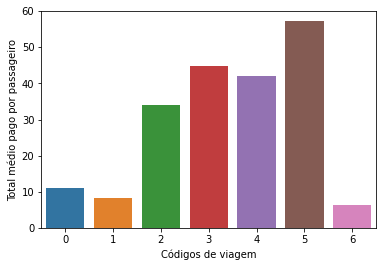

In [30]:
# Histograma do total médio por passageiro por código de viagem

sns.barplot(data = df_valores_medios, x = df_valores_medios['Códigos de viagem'], y = df_valores_medios['Total médio pago por passageiro'])

In [31]:
# Conversão da subamostra em pandas

subamostra_pandas = taxis_and_limosines_subamostra.toPandas()

Text(0, 0.5, 'Total Amount')

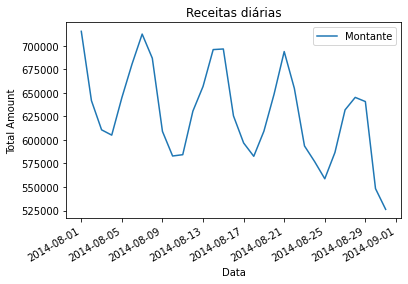

In [69]:
# Gráfico das receitas diárias ao longo do mês

receitas_diarias = subamostra_pandas.groupby(subamostra_pandas[' pickup_datetime'].dt.date).sum()

plt.plot(receitas_diarias.index, receitas_diarias[' total_amount'])
plt.legend(["Montante"])
plt.gcf().autofmt_xdate()
plt.title('Receitas diárias')
plt.xlabel('Data')
plt.ylabel('Total Amount')

In [94]:
numericas = taxis_and_limosines_subamostra.select(' passenger_count', ' trip_distance', ' pickup_longitude', ' pickup_latitude', ' rate_code', ' store_and_fwd_flag', ' dropoff_longitude', ' dropoff_latitude', ' fare_amount', ' surcharge', ' mta_tax', ' tip_amount', ' tolls_amount', ' trip_duration', ' total_amount')

numericas = numericas.withColumn(' store_and_fwd_flag', when(numericas[' store_and_fwd_flag'] == 'Y', 1).otherwise(0))

for i in numericas.columns:
    print(i, ': ', numericas.stat.corr(i, ' total_amount'))

 passenger_count :  0.015698291639990217


 trip_distance :  0.9236638149761347


 pickup_longitude :  -0.0038727737744397345


 pickup_latitude :  0.004279754854484199


 rate_code :  0.5653735408337559


 store_and_fwd_flag :  0.014237776734215224


 dropoff_longitude :  -0.003437077639327108


 dropoff_latitude :  0.003650084376583162


 fare_amount :  0.9827981937840936


 surcharge :  -0.05109163183034506


 mta_tax :  -0.29907295484690166


 tip_amount :  0.6492654979008966


 tolls_amount :  0.6735357837188547


 trip_duration :  0.8151073023644785


 total_amount :  1.0


In [93]:
# Guardar o ficheiro representativo da subamostra para utilizar no notebook contendo apenas o algoritmo

taxis_and_limosines_subamostra.write.mode("overwrite").csv("taxis_and_limosines_subamostra",header=True)